In [110]:
import math
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as si
import seaborn as sns

In [111]:
### parameters 
S0 = 100
K = 98
T = [0,0.25,0.5,0.75,1]
r = .0
delta = 0.02
mcpath = 10000
n = len(T)
#matrix N*5
np.random.seed( 420 ) 

## PART A

In [112]:
n = len(T) # number of periods
sigma = 0.23 # Constant sigma 
dt = 1/4 # Constat time interval
S = np.zeros((mcpath,n)) 
for i in range(0,mcpath):
    t = 0 
    W = 0 
    C=np.ones(5)
    for j in range(0,n):
        if j==0:
            C[j]=100
        else:
            W = np.random.normal(0,np.sqrt(dt))
            C[j]=np.exp((r-delta-0.5*sigma**2)*dt+sigma*W)
        S[i,j] = np.prod(C) # price path

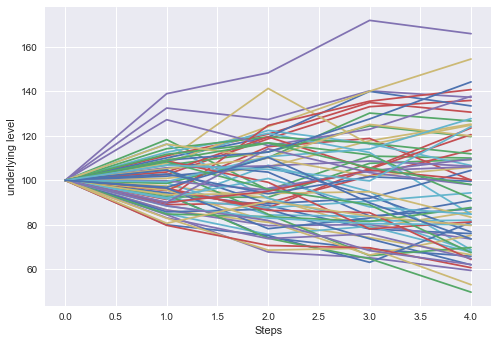

In [114]:
sdff=pd.DataFrame(S)
import matplotlib.pyplot as plt

plt.style.use('seaborn')

plt.plot(sdff.T.loc[:,0:1000:15])
plt.grid(True)
plt.xlabel('Steps')
plt.ylabel('underlying level')
plt.show()

In [115]:
# Compute A for t1 t2 t3 t3
A = np.zeros((mcpath,n-1))
A[:,0] = S[:,1]
A[:,1] = (S[:,1] + S[:,2])/2
A[:,2] = (S[:,1] + S[:,2] + S[:,3])/3
A[:,3] = (S[:,1] + S[:,2] + S[:,3] + S[:,4])/4

In [116]:
## define function for the intrinsic value
def intr(a):
    res = np.array([])
    for k in range(0,len(a)):
        if a[k] > 0:
            res = np.append(res,a[k]) 
        else:
            res = np.append(res,0)
    return res

In [117]:
p=np.zeros((mcpath,1))
C = np.zeros((mcpath,n))
C[:,n-1] = intr(S[:,n-1]-K) # intrinsic value at the last period
for i in range(1,n):
    X = np.array([np.ones(mcpath),S[:,n-1-i],S[:,n-1-i]**2,S[:,n-1-i]**3,A[:,n-1-i],A[:,n-1-i]**2,A[:,n-1-i]**3]).T # variables on which 
    Y = np.sum(C,axis = 1) # cashflows received if not exercised 
    beta = np.dot(np.linalg.pinv(np.dot(X.T,X)),np.dot(X.T,Y)) # beta coefficients 
    Y_reg = np.dot(X,beta) # continuation value
    stop = intr(A[:,n-1-i]-K) > Y_reg # determing optimal stopping points
    C[:,n-1-i] = intr(A[:,n-1-i]-K)*stop # assign optimal stopping values to the cash flows
    for j in range(0,mcpath):
        if (stop[j] == True):  
            if (C[j,n-i-1] > (C[j,n-i])):
                C[j,n-i:n] = 0 # delate cashflows after optimal strike

p=np.amax(C, 1) # consider the the intrinsic value at maturity when is never optimal to                       exercise before the maturity 

In [118]:
price = sum(p.T)/mcpath
price ## price using LSMC with constant volatility.

9.171555562209774

In [119]:
dff=pd.DataFrame(p)
dff.describe()# summary statistic of the LSMC

,0
count,10000.000000
mean,9.171556
std,14.404647
min,0.000000
25%,0.000000
50%,0.000000
75%,14.449623
max,145.162166


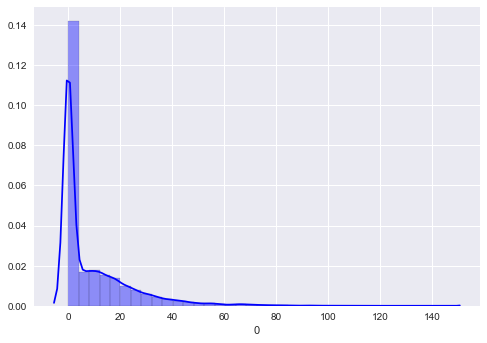

In [120]:
sns.distplot(dff[0], hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

In [121]:
## BSM price of an European Call which is the lower boundary of the price of an american       call
def bs(S, K, T, r, q, sigma):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    call = (S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call 
bs(S0, K, 1,r,delta, sigma)

8.983224650185882

## point b

In [122]:
## import implied volatilites from problem set 5
ind= pd.read_csv('/Users/francescomaizza/Documents/GitHub/advanced_derivatives/problem_set_7/strikes.csv',names=['s'])/2772.70 
mat=pd.read_csv('/Users/francescomaizza/Documents/GitHub/advanced_derivatives/problem_set_7/maturities.csv')
v=list(mat.columns)
vol= pd.read_csv('/Users/francescomaizza/Documents/GitHub/advanced_derivatives/problem_set_7/impv_total.csv',names=v)
vol.index=ind.s

In [123]:
localvol=vol.loc[K/S0] # get the implied volatiliets for our K/S0
localvol=pd.concat([pd.Series([0]), localvol])

In [124]:
localvol=localvol.iloc[0:localvol.index.get_loc('1')+1] # consider volatility upto T=1

In [125]:
xp=[float(i) for i in localvol.index]
d=np.arange(0, 13, 1)/12
d=d.tolist()
localvolint=np.interp(d, xp, localvol) #interpolate local volatilities so to have montlhy                                          periods

In [126]:
n=len(localvolint) 
S = np.zeros((mcpath,n))
for i in range(0,mcpath):
    t = 0 
    W = 0 
    C=np.ones(n)
    j=0
    dt=1/12
    for j in range(0,n):
        if j==0:
            C[j]=100
        else:
            W = np.random.normal(0,np.sqrt(dt))
            C[j]=np.exp((r-delta-0.5*localvolint[j]**2)*dt+localvolint[j]*W)
        S[i,j] = np.prod(C)

In [127]:
sdf.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,100.0,99.825825,99.784913,99.671895,99.490404,99.264744,99.066641,98.986655,98.834676,98.680368,98.478345,98.284478,98.224767
std,0.0,6.882077,9.463195,11.625182,13.318377,14.881150,16.346065,17.618377,18.758901,19.994016,21.067769,22.176433,23.237059
min,100.0,77.247105,62.596399,60.339574,60.563285,55.669864,51.735103,50.308383,47.752790,44.793273,45.032491,45.348930,40.290329
25%,100.0,94.963585,93.251743,91.626569,90.120443,88.834895,87.607299,86.422932,85.463763,84.358481,83.519811,82.226083,81.562223
50%,100.0,99.637939,99.352694,98.891744,98.674296,98.104358,97.734792,97.454067,96.926140,96.606106,96.092908,95.896634,95.343167
75%,100.0,104.415223,105.856938,107.030823,108.044798,108.657455,109.407739,109.797914,110.262858,110.810182,111.152998,111.361242,111.481513
max,100.0,131.249910,141.373064,158.361579,158.874009,170.205916,195.573739,184.626763,189.914332,201.648773,208.675173,221.350549,216.831439


In [128]:
sdf=pd.DataFrame(S)
A = np.zeros((mcpath,n-1))
for i in range(1,n):
    col = sdf.loc[: , 1:i]
    A[:,i-1] = col.mean(axis=1)


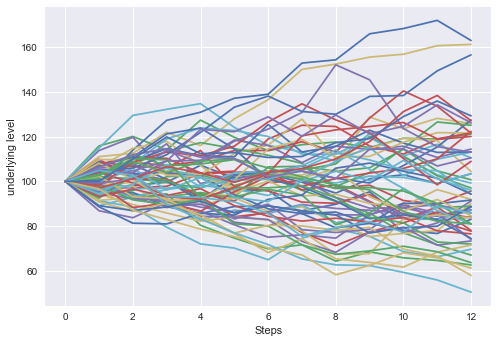

In [129]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')

 
plt.plot(sdf.T.loc[:,0:1000:15])
plt.grid(True)
plt.xlabel('Steps')
plt.ylabel('underlying level')
plt.show()

In [130]:
p=np.zeros((mcpath,1))
C = np.zeros((mcpath,n))# always possible to exercise in 5 periods
C[:,n-1] = intr(S[:,n-1]-K) # intrinsic value at the last period
for i in range(1,5):
    X = np.array([np.ones(mcpath),S[:,n-1-3*i],S[:,n-1-3*i]**2,S[:,n-1-3*i]**3,A[:,n-1-3*i],A[:,n-1-3*i]**2,A[:,n-1-3*i]**3]).T # variables on which 
    Y = np.sum(C,axis = 1) # cashflows received if not exercised 
    beta = np.dot(np.linalg.pinv(np.dot(X.T,X)),np.dot(X.T,Y)) # beta coefficients 
    Y_reg = np.dot(X,beta) # continuation value
    stop = intr(A[:,n-1-4*i]-K) > Y_reg # determing optimal stopping points
    C[:,n-1-3*i] = intr(A[:,n-1-3*i]-K)*stop # assign optimal stopping values to the cash flows
    if (stop[j] == True):  
            if (C[j,n-i-1] > (C[j,n-i])):
                C[j,n-i:n] = 0 # delate cashflows after optimal strike
                
p=np.amax(C, 1) # consider the highest continuation value (the intrinsic value at maturity)                   when is never optimal to exercise before the maturity 

In [131]:
price = sum(p.T)/mcpath
price

10.058792900649486

In [138]:
df=pd.DataFrame(p)
df.describe()

,0
count,10000.000000
mean,10.058793
std,15.380221
min,0.000000
25%,0.000000
50%,2.079682
75%,15.003654
max,118.831439


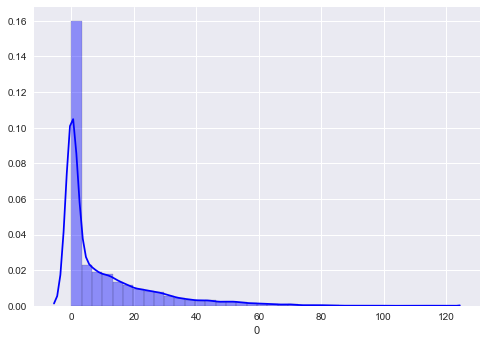

In [133]:
sns.distplot(df[0], hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

In [134]:
## lower price since do to the increase in volatility and the fact that we have a negative drift we have an underlying path in which is more optimal to wait till maturity of the the call option rather than exercise before as the price converge to the price of the european call